# Evaluation tests

Notes
- https://scikit-learn.org/stable/model_selection.html
- https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226

In [1]:
# load results

import yaml
import os.path
import pickle

# Set data paths
config          = yaml.safe_load(open("config.yaml", "r"))
results_file = os.path.join(config["EXPERIMENTS_DIRECTORY"], "results_a")

print(results_file)
if os.path.isfile(results_file):
    with open(results_file, "rb") as handle:
        results = pickle.load(handle)

/home/eml4u/EML4U/data/amazon/results_a


In [2]:
# remove cosine similarity, as it contains no p-values
del results["bow_50"]["CosineDetector"]
del results["bow_768"]["CosineDetector"]

# remove AlibiChiSquaredDetector, as every value is around 0.5
del results["bow_50"]["AlibiChiSquaredDetector"]
del results["bow_50"]["AlibiChiSquaredDetector-FDR"]

In [3]:
# percent of injected words

import numpy
target_percentages = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
negative_words_percentage = numpy.divide(target_percentages, 2)
print("negative_words_percentage", negative_words_percentage)

negative_words_percentage [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5  ]


In [4]:
fake_predictions = negative_words_percentage
fake_predictions[0] = .0012
fake_predictions = numpy.divide(.001, fake_predictions)
results['bow_50']['fake'] = {}
results['bow_50']['fake']['predictions'] = fake_predictions
results['bow_768']['fake'] = {}
results['bow_768']['fake']['predictions'] = fake_predictions
print(fake_predictions)

fake_predictions = negative_words_percentage
fake_predictions[0] = .012
fake_predictions = numpy.divide(.01, fake_predictions)
results['bow_50']['fake2'] = {}
results['bow_50']['fake2']['predictions'] = fake_predictions
results['bow_768']['fake2'] = {}
results['bow_768']['fake2']['predictions'] = fake_predictions
print(fake_predictions)

fake_predictions = [0] * 21
fake_predictions[0] = 1
results['bow_50']['perfect'] = {}
results['bow_50']['perfect']['predictions'] = fake_predictions
results['bow_768']['perfect'] = {}
results['bow_768']['perfect']['predictions'] = fake_predictions
print(fake_predictions)

[0.83333333 0.04       0.02       0.01333333 0.01       0.008
 0.00666667 0.00571429 0.005      0.00444444 0.004      0.00363636
 0.00333333 0.00307692 0.00285714 0.00266667 0.0025     0.00235294
 0.00222222 0.00210526 0.002     ]
[0.83333333 0.4        0.2        0.13333333 0.1        0.08
 0.06666667 0.05714286 0.05       0.04444444 0.04       0.03636364
 0.03333333 0.03076923 0.02857143 0.02666667 0.025      0.02352941
 0.02222222 0.02105263 0.02      ]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
# plot results

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt

def plot_results():
    linewidth=1.5
    fig, ax = plt.subplots()
    ax.plot(negative_words_percentage, results["bow_50"]["fake"]["predictions"], '--', label='fake', color='tab:gray', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_50"]["fake2"]["predictions"], ':', label='fake2', color='tab:gray', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_50"]["perfect"]["predictions"], '-.', label='perfect', color='tab:gray', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_50"]["AlibiKSDetector"]["predictions"], label='KS', color='tab:green', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_50"]["AlibiLSDDDetector"]["predictions"], label='LSDD', color='tab:orange', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_50"]["AlibiMMDDetector"]["predictions"], '--', label='MMD', color='tab:red', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_50"]["FCITDetector"]["predictions"], ':', label='FCIT', color='tab:blue', linewidth=linewidth)
    plt.legend(loc='center right')
    ax.set(xlabel='Percentage of injected negative words', ylabel='p-value',
           title='Drift detection: Bag of Words with 50 dimensions')
    ax.grid(color='#dddddd')
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    fig.set_size_inches(9, 5)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(negative_words_percentage, results["bow_768"]["fake"]["predictions"], '--', label='fake', color='tab:gray', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_768"]["fake2"]["predictions"], ':', label='fake2', color='tab:gray', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_768"]["perfect"]["predictions"], '-.', label='perfect', color='tab:gray', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_768"]["AlibiKSDetector"]["predictions"], label='KS', color='tab:green', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_768"]["AlibiLSDDDetector"]["predictions"], label='LSDD', color='tab:orange', linewidth=linewidth)
    ax.plot(negative_words_percentage, results["bow_768"]["AlibiMMDDetector"]["predictions"], '--', label='MMD', color='tab:red', linewidth=linewidth)
    plt.legend(loc='center right')
    ax.set(xlabel='Percentage of injected negative words', ylabel='p-value',
       title='Drift detection: Bag of Words with 768 dimensions')
    ax.grid(color='#dddddd')
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    fig.set_size_inches(9, 5)
    plt.show()

In [6]:
# applies method on arrays 'expected' and all results 'drift_predictions'
def evaluate(method, print_info = False):
    eval_results = {}
    for data_id in results:
        data_id_results = {}
        for detector_id in results[data_id]:
            if(print_info):
                print()
                print(data_id, detector_id)
            data_id_results[detector_id] = method(negative_words_percentage, results[data_id][detector_id]['predictions'])
        eval_results[data_id] = data_id_results
    return eval_results

# prints lists of tuples
def print_eval(eval_results, reverse=False):
    print()
    if(reverse):
        print("Final scores (higher values are better)")
    else:
        print("Final scores (lower values are better)")
    for data_id in eval_results:
        print(data_id)
        sorted_results = sorted(eval_results[data_id].items(), key=lambda item: item[1], reverse=reverse)
        for i in range(len(sorted_results)):
            print(str("{:.4f}".format(sorted_results[i][1])).zfill(10), sorted_results[i][0])

In [7]:
# simple difference
# problem: first index [0] has no drift and should be handled specially
def difference(negative_words_percentage, p_values):
    inverted_p = numpy.subtract(1, p_values)
    return numpy.average(numpy.subtract(negative_words_percentage, inverted_p))

print_eval(evaluate(difference))

if(False):
    plot_results()


Final scores (lower values are better)
bow_50
-0000.7490 FCITDetector
-0000.7029 fake
-0000.7018 perfect
-0000.6999 AlibiMMDDetector
-0000.6975 AlibiLSDDDetector
-0000.6412 fake2
-0000.5510 AlibiKSDetector
bow_768
-0000.7029 fake
-0000.7018 perfect
-0000.6909 AlibiMMDDetector
-0000.6412 fake2
-0000.5885 AlibiLSDDDetector
-0000.4278 AlibiKSDetector


In [8]:
# difference with penalty (detected drift in no-drift-data)
# better: 50 model
# problem: usage of absulute values in expected values
#          (best would be detected drift == 1, and not p-value)
#          see 768 model
def difference_penalty(negative_words_percentage, p_values):
    
    # remove first element (no injected drift)
    neg_percentage = negative_words_percentage[1:]
    p_vals = p_values[1:]
    
    inverted_p_vals = numpy.subtract(1, p_vals)
    
    # p-value first element (no injected drift)
    penalty = 1 - p_values[0]
    
    absolute_differences = numpy.absolute(numpy.subtract(neg_percentage, inverted_p_vals))
    
    average_differences = numpy.average(absolute_differences)
    
    score = average_differences + penalty
    if(True):
        print(score, "=", average_differences, "+", penalty)
    
    return score

print_eval(evaluate(difference_penalty, True))

if(False):
    plot_results()


bow_50 AlibiKSDetector
1.0439099460840224 = 0.5546988040208817 + 0.48921114206314087

bow_50 FCITDetector
1.7370211390620431 = 0.7370308530032778 + 0.9999902860587654

bow_50 AlibiMMDDetector
0.9065000072121621 = 0.7265000000596047 + 0.18000000715255737

bow_50 AlibiLSDDDetector
0.8754999762400985 = 0.7255000000819564 + 0.1499999761581421

bow_50 fake
0.8969711873523791 = 0.7303045206857125 + 0.16666666666666663

bow_50 fake2
0.8322118735237929 = 0.6655452068571263 + 0.16666666666666663

bow_50 perfect
0.7375 = 0.7375 + 0

bow_768 AlibiKSDetector
0.9152301579713822 = 0.42531329691410064 + 0.4899168610572815

bow_768 AlibiMMDDetector
1.2865000038407743 = 0.6965000002644957 + 0.5900000035762787

bow_768 AlibiLSDDDetector
0.9510000236332417 = 0.6009999997913837 + 0.3500000238418579

bow_768 fake
0.8969711873523791 = 0.7303045206857125 + 0.16666666666666663

bow_768 fake2
0.8322118735237929 = 0.6655452068571263 + 0.16666666666666663

bow_768 perfect
0.7375 = 0.7375 + 0

Final scores (lowe

# Evaluation metric

$d$ drift detector  
$n$ number experiments  
$w_i$ percentage of injected negative words of experiment $i$   
$w_1=0$ experiment without injected drift  
$p_i$ p-value of experiment $i$  

$S(d_i) = (1 - p_i) - (1 - p_1)$ evaluation score of experiment $i$ and detector $d$   

$S(d) = \sum_{i=2}^{n} \frac{S(d_i)}{w_i} \cdot \left[ \sum_{i=2}^{n} \frac{1}{w_i} \right]^{-1} $  scores weighted by injection

In [9]:
def eval_metric(negative_words_percentage, p_values):
    
    # remove first element (no injected drift)
    neg_percentage = negative_words_percentage[1:]
    p_vals = p_values[1:]
        
    # Scores 0 (bad) to 1 (good)
    scores = []
    for i in range(len(p_vals)):
        scores.append(1 - p_vals[i])
    if(True):
        print(numpy.sum(scores), "difference score")
    
    # No injected drift in first element
    # High penalty for low p-value
    penalty = 1 - p_values[0]    
    for i in range(len(scores)):
        scores[i] = scores[i] - penalty
    if(True):
        print(penalty, "penalty; p-value without drift:", p_values[0])
        print(numpy.sum(scores), "penalty score")
        
    # Earlier drift detection is better (sensitivity)
    sum_rating = 0
    for i in range(len(scores)):
        rating = 1/neg_percentage[i]
        sum_rating += rating
        scores[i] = scores[i] * rating
    
    return numpy.sum(scores) / sum_rating

print_eval(evaluate(eval_metric, True), True)

if(False):
    plot_results()


bow_50 AlibiKSDetector
16.34397605806589 difference score
0.48921114206314087 penalty; p-value without drift: 0.51078886
6.559753216803074 penalty score

bow_50 FCITDetector
19.990617060065556 difference score
0.9999902860587654 penalty; p-value without drift: 9.713941234650133e-06
-0.009188661109751806 penalty score

bow_50 AlibiMMDDetector
19.780000001192093 difference score
0.18000000715255737 penalty; p-value without drift: 0.8199999928474426
16.179999858140945 penalty score

bow_50 AlibiLSDDDetector
19.760000001639128 difference score
0.1499999761581421 penalty; p-value without drift: 0.8500000238418579
16.760000478476286 penalty score

bow_50 fake
19.856090413714256 difference score
0.16666666666666663 penalty; p-value without drift: 0.8333333333333334
16.52275708038092 penalty score

bow_50 fake2
18.56090413714253 difference score
0.16666666666666663 penalty; p-value without drift: 0.8333333333333334
15.227570803809193 penalty score

bow_50 perfect
20 difference score
0 penalty

**Why is LSDD better rated than MMD?**  
Because of the bad prediction for no injected drift (penalty = 1 - p_values[0])  
bow_768 AlibiMMDDetector  0.5900000035762787 penalty; p-value without drift: 0.4099999964237213  
bow_768 AlibiLSDDDetector 0.3500000238418579 penalty; p-value without drift: 0.6499999761581421

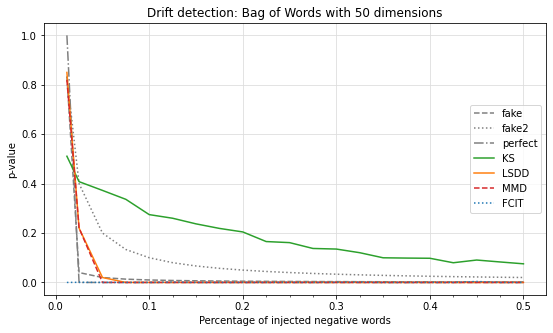

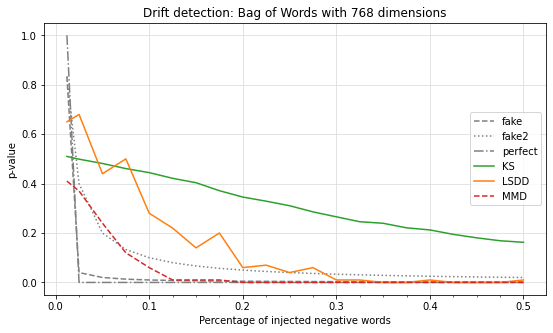

In [10]:
# visual check

plot_results()